# Trash Detection Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/trash_detection')

## Get Inputs

In [3]:
trainKeys = []
f = open("trainKeys.txt", "r")
for l in f.readlines():
    trainKeys.append(l[:-1])
f.close()

testKeys = []
f = open("testKeys.txt", "r")
for l in f.readlines():
    testKeys.append(l[:-1])
f.close()

len(trainKeys), len(testKeys)

(1200, 300)

In [4]:
import json
import numpy as np

f = open("imgAnn4_output_json_yolov1_128_v1.json")
imgAnn4_output = json.load(f)
f.close()

for k in imgAnn4_output:
    imgAnn4_output[k] = np.array(imgAnn4_output[k])

In [7]:
for i in range(8):
    for j in range(8):
        if imgAnn4_output[k][i][j][0]>0:
            print(imgAnn4_output[k][i][j])

[1.     0.8125 0.1875 2.1875 1.1875 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     1.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.    ]
[1.    0.625 0.25  0.875 0.625 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.   ]
[1.     0.375  0.1875 1.     1.     0.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.

## Model Definition

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Reshape, Concatenate, Flatten, \
                                    Dense, LeakyReLU, BatchNormalization, Layer, ReLU, Dropout
import tensorflow.keras.backend as K
import numpy as np

In [9]:
num_classes = 60
batch_size = 32
inp_dim = 128

In [10]:
idx_p = [0]
idx_bb = [1, 2, 3, 4]
idx_cls = [i for i in range(5,5+num_classes)]

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

In [11]:
def modelDef():
    x = x_input = Input(shape=(inp_dim, inp_dim, 3))

    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x) # size: 64x64

    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # size: 64x64

    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)  # size: 32x32

    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)  # size: 16x16

    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x) # size: 8x8x

    # ---

    x_prob = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
    x_boxes = Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)
    x_cls = Conv2D(num_classes, kernel_size=3, padding='same', activation='softmax', name='x_cls')(x)

    # ---

    gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
    x_boxes = x_boxes * gate
    x_cls = x_cls * gate

    # ---

    x = Concatenate()([x_prob, x_boxes, x_cls])

    model = tf.keras.models.Model(x_input, x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.003)
    model.compile(loss=loss_func, optimizer=opt)
    
    return model

model = modelDef()
print(model.summary())
del model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 32)   0           ['conv2d[0][0]']                 
                                                                                              

## Dataloader function

In [12]:
import random
import cv2

def dataGenerator(modelOutput, keys, isRandom=True):
    keys_copy = keys.copy()
    modelOutput_copy = modelOutput.copy()

    if isRandom:
        random.shuffle(keys_copy)

    i = 0
    while True:
        if i + batch_size <= len(keys_copy):
            reqKeys = keys_copy[i:i+batch_size]

            images = [cv2.imread("./data/"+k) for k in reqKeys]
            images = [cv2.resize(image, (inp_dim, inp_dim)) for image in images]
            images = np.array(images, dtype='float32')/255.

            out = np.array([modelOutput_copy[k] for k in reqKeys])

            yield images, out
            i+=batch_size
        else:
            i= 0
            continue

In [13]:
x = next(dataGenerator(imgAnn4_output, trainKeys))
print(x[0].shape, x[1].shape)
del x

(32, 128, 128, 3) (32, 8, 8, 65)


## Training

In [14]:
def getBBoxes(yt, yp, threshold):
    bboxes = []
    for i in range(yt.shape[0]):
        for j in range(yt.shape[1]):
            if yt[i][j][0] >= threshold and yp[i][j][0] >= threshold:
                bboxes.append([yt[i][j][1:5], yp[i][j][1:5]])

    return bboxes

def getIoUOneBox(bb1, bb2):
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2]+bb1[0], bb2[2]+bb2[0])
    y_bottom = min(bb1[3]+bb1[1], bb2[3]+bb2[1])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
        
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    bb1_area = (bb1[2]) * (bb1[3])
    bb2_area = (bb2[2]) * (bb2[3])
    
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    if iou < 0:
        return 0
    if iou > 1:
        return 1
    return iou

def getIouMultipleBoxes(bboxes):
    iou = 0
    for bb in bboxes:
        box1 = bb[0]
        box2 = bb[1]
        iou += getIoUOneBox(box1, box2)
    if len(bboxes) == 0:
        return 0
    return iou/len(bboxes)

def getIoU(y_pred, testKeys, threshold = 0.5):
    reqOut = [imgAnn4_output[k] for k in testKeys[:len(y_pred)]]

    iouScores = []
    for i in range(len(reqOut)):
        bboxes = getBBoxes(reqOut[i], y_pred[i], threshold)
        iouScores.append(getIouMultipleBoxes(bboxes))

    return sum(iouScores)/len(iouScores)

In [ ]:
model = modelDef()
model.load_weights("model_yolo1_128_v2.h5")

currIou = 0.007443549096774181

for e in range(30):
    history = model.fit(x=dataGenerator(imgAnn4_output, trainKeys),
                        steps_per_epoch=int(len(trainKeys) / batch_size),
                        epochs=1,
                        verbose=1)
    y_pred = model.predict(x=dataGenerator(imgAnn4_output, testKeys, isRandom=False),
                      steps=int(len(testKeys) / batch_size),
                      verbose=1,
                      batch_size=batch_size)
    
    iou = getIoU(y_pred, testKeys)
    print("Epoch:",e+1,"\tIOU:",iou)
    
    if iou > currIou:
        model.save_weights("model_yolo1_128_v2.h5")

## Prediction

In [15]:
from matplotlib import pyplot as plt
def drawBoundingBox(fname, bboxes, captions, output_shape=None, showGrid=False, showCaption=False):
    imgFile = "./data/"+fname

    image = cv2.imread(imgFile)

    if output_shape is not None:
        image = cv2.resize(image, output_shape)

    for i,bbox in enumerate(bboxes):
        start_point = (int(bbox[0]), int(bbox[1]))
        end_point = (int(bbox[0])+int(bbox[2]), int(bbox[1])+int(bbox[3]))
        color = (255, 0, 0)
        thickness = 1

        cx = int(bbox[0] + (bbox[2]/2))
        cy = int(bbox[1] + (bbox[3]/2))
        
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        image = cv2.circle(image, (cx,cy), 1, color, thickness)

        font = cv2.FONT_HERSHEY_SIMPLEX
        if showCaption:
            image = cv2.putText(image, categ[captions[i]], (int(bbox[0]), int(bbox[1])-5), font, 0.25, (0, 255, 0), thickness, cv2.LINE_AA)

    if showGrid:
        for i in range(32):
            sp = (int(i*inp_dim/32),0)
            ep = (int(i*inp_dim/32),inp_dim)
            image = cv2.line(image, sp, ep, (0, 255, 0), thickness) 

            sp = (0,int(i*inp_dim/32))
            ep = (inp_dim,int(i*inp_dim/32))
            image = cv2.line(image, sp, ep, (0, 255, 0), thickness)

    plt.imshow(image)
    plt.show()

In [ ]:
model = modelDef()
model.load_weights("model_yolo1_128.h5")

images = [cv2.imread("./1.jpeg")]
images = [cv2.resize(image, (inp_dim, inp_dim)) for image in images]
images = np.array(images, dtype='float32')/255.

y_pred = model.predict(x=images, verbose=1)
y_pred.shape

1/1 [==============================] - 1s 656ms/step


(1, 8, 8, 65)

In [16]:
model = modelDef()
model.load_weights("model_yolo1_128_v2.h5")

y_pred = model.predict(x=dataGenerator(imgAnn4_output, testKeys, isRandom=False),
                      steps=int(len(testKeys) / batch_size),
                      verbose=1)

9/9 [==============================] - 174s 22s/step


In [17]:
def getIouMultipleBoxes2(bboxes):
    iou = 0
    for bb in bboxes:
        box1 = bb[0]
        box2 = bb[1]
        iou = max(iou,getIoUOneBox(box1, box2))
    if len(bboxes) == 0:
        return 0
    return iou

def getBBoxes2(yt, yp, threshold):
    bboxes = []
    for i in range(yt.shape[0]):
        for j in range(yt.shape[1]):
            if yt[i][j][0] >= threshold and yp[i][j][0] >= threshold:
                w = yp[i][j][3]*inp_dim/8
                h = yp[i][j][4]*inp_dim/8

                bxmax = int((i+1)*inp_dim/8)
                bxmin = int((i)*inp_dim/8)
                bymax = int((j+1)*inp_dim/8)
                bymin = int((j)*inp_dim/8)

                cx = yp[i][j][1]*(bxmax-bxmin) + bxmin
                cy = yp[i][j][2]*(bymax-bymin) + bymin

                x = cx - w/2
                y = cy - h/2
                bboxes.append([yt[i][j][1:5], [x,y,w,h]])

    return bboxes

def getIoU2(y_pred, testKeys, threshold = 0.5):
    reqOut = [imgAnn4_output[k] for k in testKeys[:len(y_pred)]]

    maxScore = 0
    maxScores = []
    maxT = 0

    for t in [0.4+i*0.05 for i in range(14)]:
        iouScores = []
        for i in range(len(reqOut)):
            bboxes = getBBoxes2(reqOut[i], y_pred[i], t)
            iouScores.append(getIouMultipleBoxes2(bboxes))
        if max(iouScores) > maxScore:
            maxScore = max(iouScores)
            maxT = t
            maxScores = iouScores

    return maxScores, maxScore, maxT

In [18]:
maxScores, maxScore, maxT = getIoU2(y_pred, testKeys)
maxScore

0

In [19]:
aa = np.argsort(np.array(maxScores))[::-1][:15]

In [20]:
[testKeys[i] for i in aa]

[]

In [ ]:
f = open("categories.txt")
categ = {}

c = 0
for l in f.readlines():
    categ[c] = l[:-1]
    c+=1
    
f.close()

In [ ]:
def mergeBbox(bboxes, captions, threshold = 0.2):
    stay = True

    while stay:
        stay = False
        for i in range(len(bboxes)):
            for j in range(i+1, len(bboxes)):
                if getIoUOneBox(bboxes[i], bboxes[j]) > threshold:
                    stay = True
                    newBboxes = bboxes[:i] + bboxes[i+1:j] + bboxes[j+1:]
                    newCaptions = captions[:i] + captions[i+1:j] + captions[j+1:]
                    
                    newX1 = min(bboxes[i][0], bboxes[j][0])
                    newX2 = max(bboxes[i][0]+bboxes[i][2], bboxes[j][0]+bboxes[j][2])
                    newY1 = min(bboxes[i][1], bboxes[j][1])
                    newY2 = max(bboxes[i][1]+bboxes[i][3], bboxes[j][1]+bboxes[j][3])

                    newBboxes += [[newX1,newY1,newX2-newX1,newY2-newY1]]
                    bboxes = newBboxes
                    newCaptions += [captions[i]]
                    captions = newCaptions

                    break
            if stay:
                break

    return bboxes, captions

In [ ]:
for index in aa:
    fname = testKeys[index]

    out = y_pred[index]

    bboxes = []
    captionNum = []

    for i in range(8):
        for j in range(8):
            if out[i][j][0] >= maxT:
                bb = []

                # x = out[i][j][1]
                # y = out[i][j][2]
                # w = out[i][j][3]
                # h = out[i][j][4]

                w = out[i][j][3]*inp_dim/8
                h = out[i][j][4]*inp_dim/8

                bxmax = int((i+1)*inp_dim/8)
                bxmin = int((i)*inp_dim/8)
                bymax = int((j+1)*inp_dim/8)
                bymin = int((j)*inp_dim/8)

                cx = out[i][j][1]*(bxmax-bxmin) + bxmin
                cy = out[i][j][2]*(bymax-bymin) + bymin

                x = cx - w/2
                y = cy - h/2
                
                captionNum.append(np.argsort(out[i][j][5:])[-1])
                bboxes.append([x,y,w,h])
                   
    newBBoxes, newCaptions = mergeBbox(bboxes, captionNum, 0)
    drawBoundingBox(fname, newBBoxes, newCaptions, output_shape=(inp_dim,inp_dim))

Output hidden; open in https://colab.research.google.com to view.

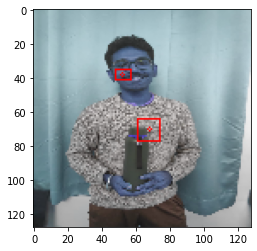

In [ ]:
for index in [0]:
    fname = "1.jpeg"

    out = y_pred[index]

    bboxes = []
    captionNum = []

    for i in range(8):
        for j in range(8):
            if out[i][j][0] >= 0.4:
                bb = []

                # x = out[i][j][1]
                # y = out[i][j][2]
                # w = out[i][j][3]
                # h = out[i][j][4]

                w = out[i][j][3]*inp_dim/8
                h = out[i][j][4]*inp_dim/8

                bxmax = int((i+1)*inp_dim/8)
                bxmin = int((i)*inp_dim/8)
                bymax = int((j+1)*inp_dim/8)
                bymin = int((j)*inp_dim/8)

                cx = out[i][j][1]*(bxmax-bxmin) + bxmin
                cy = out[i][j][2]*(bymax-bymin) + bymin

                x = cx - w/2
                y = cy - h/2
                
                captionNum.append(np.argsort(out[i][j][5:])[-1])
                bboxes.append([x,y,w,h])
                   
    newBBoxes, newCaptions = mergeBbox(bboxes, captionNum, 0)
    drawBoundingBox(fname, newBBoxes, newCaptions, output_shape=(inp_dim,inp_dim))